<a href="https://colab.research.google.com/github/newu2012/ComputerVisionCourse/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B8/lab4_classification_cnn_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сверточные нейронные сети в PyTorch

---

## Сверточная нейронная сеть классификации изображений

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

try:  
    from torchsummary import summary
except:
  !pip install -U torchsummary
  from torchsummary import summary

Рассмотрим задачу классификации для датасета Cifar10 - это классический датасет с изображениями, относящимися к 10 классам.
Каждое изображение трех-цветное и имеет размер 32 на 32 пикслея (то есть представляет тензор размером 3х32х32).

Например Cifar10 содержит следующие изображения.

![](https://debuggercafe.com/wp-content/uploads/2019/10/cifar10_plot.png)

Загрузим датасет и проведем его нормализацию

In [3]:
transform =\
    transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize( 
                            mean = (0.5, 0.5, 0.5), 
                            std  = (0.5, 0.5, 0.5)  )
                       ])

BATCH_SIZE = 4

trainset = torchvision.datasets.CIFAR10(root      = './data', 
                                        train     = True,
                                        download  = True, 
                                        transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size = BATCH_SIZE,
                                          shuffle    = True)

testset = torchvision.datasets.CIFAR10(root      = './data', 
                                       train     = False,
                                       download  = True, 
                                       transform = transform)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size = BATCH_SIZE,
                                         shuffle    = False)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на примеры изображений

In [34]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    
    plt.figure(figsize=(16,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

batch = trainloader

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

NameError: ignored

Теперь опишем класс сети. Будем использовать классическую сеть LeNet. Данная сеть была предложена в 1998 году и является одной из первых попыток разработки современного deep learning. 

Сеть имеет следующую архитектуру

![](https://miro.medium.com/max/3600/1*-NnRGtEsiLHfNnUCSXoa-Q.png)

Таким образом сеть имеет:
 * входной слой для изображений 32х32 ( в нашем случае 3х32х32),
 * два сверточных слоя, 
 * каждый сверточный слой имеет также макс-пулинг субдискретизацию,
 * слой векторизации карты признаков (приобразования матрицы в вектор путем ее "разворачивания",
 * два полносвязных внутренних слоя,
 * выходной слой - слой классификации с 10 выходами.

Также особенности архитектуры:
* свертка валидная (с уменьшением размера карты признаков на размер ядра - 1)$^*$;
* ядро свертки имеет размер 5х5 (размер ядра = 5);
* макс-пулин выполняется с шагом 2 по тайлам 2х2;
* первый сверточный слой выдает 6 карт признаков 14х14 (после макс-пулинга);
* второй сверточный слой выдает 16 карт признаков 5х5 (после макс-пулинга);
* слой разворачивания принимает 16 карт признаков 5х5 и выдет вектор $1х16*5*5$ (1х400);
* первый полносвязный слой имеет 120 выходов (120 перцептронов);
* второй полносвязный слой имеет на выходе 84 перцептрона.

$^*$Вобщем случае размер выхода свертки можно расчитать как: W=(W−F+2P)/S+1, where W is input size, F is kernel size, S is stride applied, and P is padding. 

**Реализуем сверточную сеть LeNet в виде класса, !Однако, для учебных целей добавим в сеть батч-нормализацию и дроп-ауты**

In [5]:
class CNNModel(nn.Module):
    
    N_CLASSES = 10  
    
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # convolution
        self.conv1   = nn.Conv2d(in_channels  = 3, 
                                 out_channels = 6, 
                                 kernel_size  = 5)       

        self.conv2   = nn.Conv2d(in_channels  = 6, 
                                 out_channels = 16,
                                 kernel_size  = 5)
        
        self.bn  = nn.BatchNorm2d(16)  
        self.dropout = nn.Dropout(0.1)
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2, 
                                    stride      = 2)
        
        # classification
        self.fc1 = nn.Linear(in_features  = 16 * 5 * 5, 
                             out_features = 120)
        
        self.fc2 = nn.Linear(in_features  = 120, 
                             out_features = 84)
        
        self.fc_out = nn.Linear(in_features = 84, 
                                out_features = self.N_CLASSES)
    
    # specific operation
    def flatten(self, x):
        return x.view(-1, 16 * 5 * 5)
    
    def forward(self, x):
        
        # 1-st layer
        x = self.conv1(x)
        x = torch.relu(x)        
        x = self.maxpool(x)
        x = self.dropout(x)
        
        #2-nd layer
        x = self.conv2(x)         
        x = self.bn(x)        
        x = torch.relu(x)        
        x = self.maxpool(x)

        #flatten
        x = self.flatten(x)
        
        # 1-st fc layer
        x = self.fc1(x)
        x = torch.relu(x)
        
        # 2-nd fc layer
        x = self.fc2(x)
        x = torch.relu(x)
        
        # output layer
        x = self.fc_out(x)
        
        return x#torch.softmax(x, dim=1)

In [6]:
print(images.shape)

torch.Size([4, 3, 32, 32])


**Опишим настрой**

In [7]:
LR = 0.001
cnn_net   = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_net.parameters(), lr=LR)


Посмотрим структуру параметров созданной сети

In [8]:
for name, param in cnn_net.named_parameters():
    print(name, '\t structure =',list(param.size()))

conv1.weight 	 structure = [6, 3, 5, 5]
conv1.bias 	 structure = [6]
conv2.weight 	 structure = [16, 6, 5, 5]
conv2.bias 	 structure = [16]
bn.weight 	 structure = [16]
bn.bias 	 structure = [16]
fc1.weight 	 structure = [120, 400]
fc1.bias 	 structure = [120]
fc2.weight 	 structure = [84, 120]
fc2.bias 	 structure = [84]
fc_out.weight 	 structure = [10, 84]
fc_out.bias 	 structure = [10]


In [9]:
summary(cnn_net,input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
           Dropout-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
       BatchNorm2d-5           [-1, 16, 10, 10]              32
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 62,038
Trainable params: 62,038
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.24
Estimated Total Size (MB): 0.33
---------------------------------------------

**Процесс обучения**

In [10]:
EPOHS = 5

for epoch in range(EPOHS):  # loop over the dataset multiple times
    cnn_net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize        
        outputs = cnn_net(inputs)        
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.896
[1,  4000] loss: 1.670
[1,  6000] loss: 1.607
[1,  8000] loss: 1.546
[1, 10000] loss: 1.522
[1, 12000] loss: 1.478
[2,  2000] loss: 1.415
[2,  4000] loss: 1.391
[2,  6000] loss: 1.383
[2,  8000] loss: 1.356
[2, 10000] loss: 1.359
[2, 12000] loss: 1.357
[3,  2000] loss: 1.290
[3,  4000] loss: 1.307
[3,  6000] loss: 1.291
[3,  8000] loss: 1.265
[3, 10000] loss: 1.263
[3, 12000] loss: 1.267
[4,  2000] loss: 1.217
[4,  4000] loss: 1.225
[4,  6000] loss: 1.228
[4,  8000] loss: 1.215
[4, 10000] loss: 1.213
[4, 12000] loss: 1.202
[5,  2000] loss: 1.185
[5,  4000] loss: 1.180
[5,  6000] loss: 1.166
[5,  8000] loss: 1.171
[5, 10000] loss: 1.164
[5, 12000] loss: 1.171
Finished Training


**Сохраним результат**

In [11]:
PATH = './cifar_net.pth'
torch.save(cnn_net.state_dict(), PATH)

**Загрузим результат**

In [12]:
cnn_net = CNNModel()
cnn_net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

**Проверим результат на тесте**

In [13]:
cnn_net.eval()
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = cnn_net(images)
print(outputs)

tensor([[ -3.6931,  -3.1442,  -1.2017,   0.4320,  -1.3800,  -0.3518,  -1.0652,
          -2.3568,  -1.7007,  -3.4291],
        [  1.2083,   1.1633,  -5.2502,  -6.5320,  -6.0350,  -7.8968,  -7.2149,
          -6.2938,   1.2196,  -0.3644],
        [  0.6830,   0.0396,  -1.7871,  -2.3763,  -1.5479,  -2.7990,  -3.3531,
          -1.8973,  -0.0496,  -0.0418],
        [  2.2801,  -6.1689,  -3.2728,  -7.6240,  -5.9766, -10.4014,  -6.3436,
          -9.6883,   1.2562,  -6.4573]], grad_fn=<AddmmBackward0>)


**Приведем результат к более понятному виду**
Каждый номер в выходном тензоре будет класс соответствующий картинке батча

In [14]:
_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([3, 8, 0, 0])


**Посмотрим, что получилось**

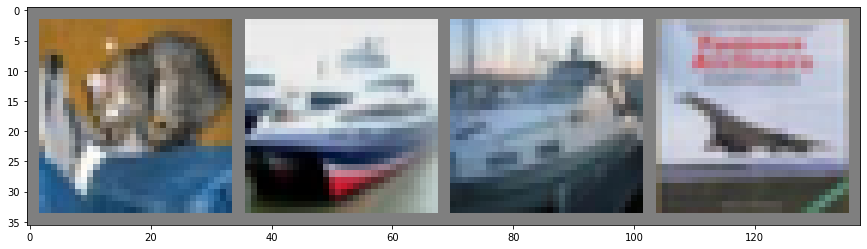

GroundTruth:    cat  ship  ship plane
Predicted :     cat  ship plane plane


In [15]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted :  ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

**Попробуем посчитать точность как число правильно классифицированных изобаржений к общему числу изображений**

In [16]:
cnn_net.eval()
correct = 0
total   = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs        = cnn_net(images)
        _, predicted    = torch.max(outputs.data, 1)
        total   += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 60 %


**Проведем анализ по каждому классу**

In [17]:
cnn_net.eval()
class_correct = list(0. for i in range(10))
class_total   = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 75 %
Accuracy of   car : 73 %
Accuracy of  bird : 42 %
Accuracy of   cat : 29 %
Accuracy of  deer : 63 %
Accuracy of   dog : 50 %
Accuracy of  frog : 66 %
Accuracy of horse : 68 %
Accuracy of  ship : 68 %
Accuracy of truck : 65 %


#### Упражнение 1 
Добавьте к процессу обучения валидацию и добавьте валидационный датасет.

In [13]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [5]:
dataset = torchvision.datasets.CIFAR10(root='data/', download=True, transform=ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


In [15]:
device = torch.device('cpu')

In [18]:
transform =\
    transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize( 
                            mean = (0.5, 0.5, 0.5), 
                            std  = (0.5, 0.5, 0.5)  )
                       ])

BATCH_SIZE = 4

torch.manual_seed(2012)
val_size = 5000
train_size = len(dataset) - val_size

train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_set, 
                                          batch_size = BATCH_SIZE,
                                          shuffle    = True,
                                          pin_memory = True)

val_loader = DataLoader(val_set, 
                        BATCH_SIZE, 
                        pin_memory  = True)


test_set = torchvision.datasets.CIFAR10(root      = './data', 
                                       train     = False,
                                       download  = True, 
                                       transform = transform)

test_loader = torch.utils.data.DataLoader(test_set, 
                                         batch_size = BATCH_SIZE,
                                         shuffle    = False)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [29]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_acc: {:.4f}, val_loss: {:.4f}".format(epoch, result['val_acc'], result['val_loss']))

In [21]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(model, train_loader, val_loader, opt_func=torch.optim.SGD):
    epochs = 5
    lr = 0.001
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
class CNNModel(nn.Module):
    N_CLASSES = 10  
    def __init__(self):
        super(CNNModel, self).__init__()
        # convolution
        self.conv1   = nn.Conv2d(in_channels  = 3, 
                                 out_channels = 6, 
                                 kernel_size  = 5)       
        self.conv2   = nn.Conv2d(in_channels  = 6, 
                                 out_channels = 16,
                                 kernel_size  = 5)
        self.bn  = nn.BatchNorm2d(16)  
        self.dropout = nn.Dropout(0.1)
        self.maxpool = nn.MaxPool2d(kernel_size = 2, 
                                    stride      = 2)
        # classification
        self.fc1 = nn.Linear(in_features  = 16 * 5 * 5, 
                             out_features = 120)
        self.fc2 = nn.Linear(in_features  = 120, 
                             out_features = 84)
        self.fc_out = nn.Linear(in_features = 84, 
                                out_features = self.N_CLASSES)
    # specific operation
    def flatten(self, x):
        return x.view(-1, 16 * 5 * 5)
    def forward(self, x):
        # 1-st layer
        x = self.conv1(x)
        x = torch.relu(x)        
        x = self.maxpool(x)
        x = self.dropout(x)
        #2-nd layer
        x = self.conv2(x)         
        x = self.bn(x)        
        x = torch.relu(x)        
        x = self.maxpool(x)
        #flatten
        x = self.flatten(x)
        # 1-st fc layer
        x = self.fc1(x)
        x = torch.relu(x)
        # 2-nd fc layer
        x = self.fc2(x)
        x = torch.relu(x)
        # output layer
        x = self.fc_out(x)
        return x#torch.softmax(x, dim=1)

In [22]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [20]:
input_size = 3*32*32
output_size = 10

In [24]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        return out

In [25]:
model = to_device(CIFAR10Model(), device)

history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.11959999799728394, 'val_loss': 2.3040788173675537}]

In [26]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [27]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [30]:
history += fit(model, train_loader, val_loader)

Epoch [0], val_loss: 1.7146, val_acc: 0.3866
Epoch [1], val_loss: 1.6574, val_acc: 0.4034
Epoch [2], val_loss: 1.6256, val_acc: 0.4166
Epoch [3], val_loss: 1.5811, val_acc: 0.4390
Epoch [4], val_loss: 1.5492, val_acc: 0.4518


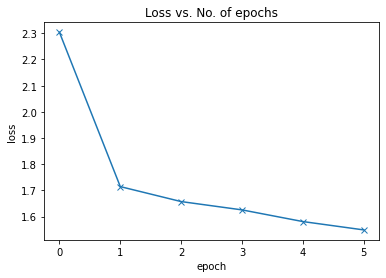

In [31]:
plot_losses(history)

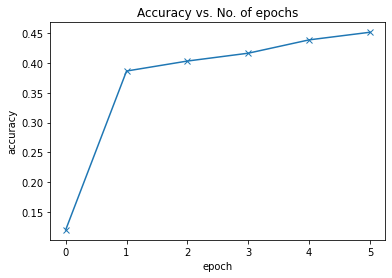

In [32]:
plot_accuracies(history)

In [33]:
evaluate(model, test_loader)

{'val_acc': 0.3813999891281128, 'val_loss': 1.8320207595825195}

In [37]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    
    plt.figure(figsize=(16,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

batch = train_loader

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

AttributeError: ignored

#### Упражнение 2
Проанализируйте полученные результаты, уберите из обучающей выборки класс с наименьшей точностью, проведите повторное обучение.


- - -

## Оптимизация  обучения модели сверточной сети

**Инициализация весов модели**

In [ ]:
cnn_net = CNNModel()
        
def init_weights(m):
    # for differernt types of layers different initialization could be applied
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)
    
    #same as type(m) == nn.Conv2d, but more correct to use isinstance   
    if isinstance(m, nn.Conv2d):  
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)   

cnn_net.apply(init_weights);

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_net.parameters(), lr=0.001)

Проверим как прошла инициализация для значений смещений

In [ ]:
for name, p in cnn_net.named_parameters():    
    if 'bias' in name:
        print(p,'\n')

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True) 

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True) 

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True) 

Parameter containing:
tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.010

Также посмортим веса для одного из слоев

In [ ]:
print(cnn_net.fc2.weight)

Parameter containing:
tensor([[-0.0049,  0.1568, -0.1938,  ...,  0.0210,  0.2001,  0.0854],
        [ 0.2390,  0.1583,  0.1660,  ...,  0.2324, -0.1878, -0.0452],
        [-0.1908,  0.0208, -0.0475,  ..., -0.1081, -0.0418,  0.0394],
        ...,
        [-0.1874, -0.2636,  0.0752,  ...,  0.1175, -0.1062, -0.1552],
        [ 0.0119, -0.1899, -0.2029,  ...,  0.1675,  0.0606, -0.0726],
        [ 0.2841,  0.1060, -0.0233,  ..., -0.1134, -0.0474,  0.1394]],
       requires_grad=True)


**Регуляризаия**

используем эластическую регуляризацию для весов и для смещения.

In [ ]:
EPOHS = 5
lambda_l1 = 1e-5
lambda_l2 = 1e-3
for epoch in range(EPOHS):  # loop over the dataset multiple times
    cnn_net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize        
        outputs = cnn_net(inputs)        
        loss    = criterion(outputs, labels)
        
        l1_regularization = 0
        l2_regularization = 0
        
        for p in cnn_net.parameters():
            l1_regularization += torch.abs(p).sum()
            l2_regularization += torch.pow(p,2).sum()     

        loss += lambda_l1*l1_regularization + lambda_l2*l2_regularization
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


print('Finished Training')

[1,  2000] loss: 2.244
[1,  4000] loss: 1.931
[1,  6000] loss: 1.801
[1,  8000] loss: 1.731
[1, 10000] loss: 1.704
[1, 12000] loss: 1.662
[2,  2000] loss: 1.621
[2,  4000] loss: 1.619
[2,  6000] loss: 1.598
[2,  8000] loss: 1.592
[2, 10000] loss: 1.588


KeyboardInterrupt: 

посмотрим на результат


In [ ]:
cnn_net.eval()
class_correct = list(0. for i in range(10))
class_total   = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

#### Упражнение 3
Проведите инициализацию смещения слоя батч-нормализации нулями.


#### Упражнение 4
1. Исключите из регуляризации слой батч-нормализации.
2. Введите особую процедуру регуляризации для выходного слоя сети
<details>
<summary>Click here for hint</summary>
  Обратится к конкретному слою можно
```
    torch.norm(model.fc1.weight, p=1)
```

## Перенос обучения

На практике очень редко кто-то пытается обучить всю сверточную сеть с нуля (со случайной инициализацией), потому что относительно редко имеется набор данных достаточного размера и достаточное время/вычислительные рессурсы для обучения. Вместо этого обычно используют предварительно обученную сеть (предобученную на очень большом наборе данных, например, ImageNet, который содержит 1,2 миллиона изображений с 1000 категориями). Результаты предобученной сети используют либо как инициализацию, либо как фиксированный экстрактор признаков (кодировщик признаков).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torchsummary import summary

Загрузим предварительно обученную модель ResNet18

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True)
summary(resnet,input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [ ]:
for name, param in resnet.named_parameters():
    print(name, '\t structure =',list(param.size()))

conv1.weight 	 structure = [64, 3, 7, 7]
bn1.weight 	 structure = [64]
bn1.bias 	 structure = [64]
layer1.0.conv1.weight 	 structure = [64, 64, 3, 3]
layer1.0.bn1.weight 	 structure = [64]
layer1.0.bn1.bias 	 structure = [64]
layer1.0.conv2.weight 	 structure = [64, 64, 3, 3]
layer1.0.bn2.weight 	 structure = [64]
layer1.0.bn2.bias 	 structure = [64]
layer1.1.conv1.weight 	 structure = [64, 64, 3, 3]
layer1.1.bn1.weight 	 structure = [64]
layer1.1.bn1.bias 	 structure = [64]
layer1.1.conv2.weight 	 structure = [64, 64, 3, 3]
layer1.1.bn2.weight 	 structure = [64]
layer1.1.bn2.bias 	 structure = [64]
layer2.0.conv1.weight 	 structure = [128, 64, 3, 3]
layer2.0.bn1.weight 	 structure = [128]
layer2.0.bn1.bias 	 structure = [128]
layer2.0.conv2.weight 	 structure = [128, 128, 3, 3]
layer2.0.bn2.weight 	 structure = [128]
layer2.0.bn2.bias 	 structure = [128]
layer2.0.downsample.0.weight 	 structure = [128, 64, 1, 1]
layer2.0.downsample.1.weight 	 structure = [128]
layer2.0.downsample.1.bi

Теперь нам нужно заморозить все параметры для экстрактора признаков. Для этого нам нужно установить `requires_grad == False`, чтобы заморозить параметры, чтобы градиенты не вычислялись в `backward()`.

In [ ]:
#freeze all parameters
for param in resnet.parameters():
    param.requires_grad = False

Для создания нашего собственного классификатора нам нужно сбросить последний полносвязанный слой.

In [ ]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = resnet.fc.in_features

resnet.fc = nn.Linear(num_ftrs, len(classes))


NameError: name 'classes' is not defined

Определим особенности дообучения сети. Будем обучать только последний слой.

In [ ]:
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_resnet = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

NameError: name 'device' is not defined

In [ ]:
EPOHS = 5

for epoch in range(EPOHS):  # loop over the dataset multiple times
    resnet.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer_resnet.zero_grad()

        # forward + backward + optimize        
        outputs = resnet(inputs)        
 
        loss    = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer_resnet.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
resnet.eval()
class_correct = list(0. for i in range(10))
class_total   = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = resnet(images)
       
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

### Упражнение 5
1. Переобучить сеть resnet полностью (используя предобученные параметры как инициализацию).
2. Сравните результаты с полученными выше.

*Примечание* Если у вас нет GPU, то рекомендуем использовать Google Colab c включенным GPU.
Для смены среды выполнения (**runtime**) выбирите **Change runtime type** в соответствующем меню.
<br><u><b><Large>После экспериментов не забудьте вернуть среду на `None` так как время выделяемое для работы GPU ограничено.<b><u>

<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/uc14.png" width="500">
<img src="https://course.fast.ai/images/colab/04.png" width="350">


- - -